In [1]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Dissertação Caio


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Dissertação Caio


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

from parametros_OM import Xi_y, m_o, Ca_pot, q_hat, C_dv, C_0l, St, c

n_train = 25
n_parts = 10


In [3]:
def polynomial(u, *coefficients):
    return sum(coef * u**i for i, coef in enumerate(coefficients[::-1]))

def polynomial_piecewise(u, coefficients, lower_limits, upper_limits):
    for i in len(coefficients):
        if u>lower_limits[i] and u<upper_limits[i]:
            return polynomial(u, *coefficients[i])

def fit_train_samples(U, A, eps, train_indices, degreeA=4, degreeEps=4):
    coeff_A, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A[train_indices],
                         p0=[1]*(degreeA+1))

    coeff_eps, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                           U[train_indices], eps[train_indices],
                           p0=[1]*(degreeEps+1))

    return {
        'coefficients_A': coeff_A,
        'coefficients_eps': coeff_eps,
    }

def om_system(x, eps, A, Ur):
    q, q_pd, y, y_pd = x
    S = St * Ur
    term1 = (Ur**2 / (2 * np.pi**3 * (m_o + Ca_pot)))
    term2 = (c * q - 2 * np.pi * C_dv * y_pd / Ur) * np.sqrt(1 + (2 * np.pi * y_pd / Ur)**2)
    y_sd = term1 * term2 - 2 * Xi_y * y_pd - y
    q_sd = - eps * S * (q**2 - 1) * q_pd - S**2 * q + y_sd * A

    return [q_pd, q_sd, y_pd, y_sd]

def predict(Ur, t, x0, eps, A, method='RK45'):

    sol = solve_ivp(fun=lambda t, x: om_system(x, eps, A, Ur),
                    t_span=[t[0], t[-1]],
                    y0=x0,
                    t_eval=t,
                    method=method,
                    rtol=1e-5,
                    atol=1e-7)

    Y_predicted = sol.y[2]
    Q_predicted = sol.y[0]

    return Y_predicted, Q_predicted


In [4]:
prefix = './dados/dados experimentais/Data2025mstar26number'
prefixU = './dados/dados experimentais/Ur2025mstar26number'

np.random.seed(42)
all_idxs = list(5*np.random.permutation(list(range(38))) + 95)
all_idxs.remove(190)

allY = np.zeros((len(all_idxs), 18000))
allU = np.zeros(len(all_idxs))
all_n = len(all_idxs)

for i, idx in enumerate(all_idxs):
    if idx == 190:
        pass
    else:
      dados = np.loadtxt(prefix + str(idx), delimiter=',')
      dadosU = np.loadtxt(prefixU + str(idx))
      allY[i, :] = dados[:, 1]
      allU[i] = np.mean(dadosU)

proc_data_path = './dados/'

U = np.load(proc_data_path + 'U.npy')
T = np.load(proc_data_path + 'T.npy')

Y_filtered_parts = np.load(proc_data_path + 'Y_filtered_parts.npy')
Y_pd_filtered_parts = np.load(proc_data_path + 'Y_pd_filtered_parts.npy')
Q_filtered_parts = np.load(proc_data_path + 'Q_filtered_parts.npy')
Q_pd_filtered_parts = np.load(proc_data_path + 'Q_pd_filtered_parts.npy')

Y_filtered = np.concatenate(Y_filtered_parts, axis=1)
Y_pd_filtered = np.concatenate(Y_pd_filtered_parts, axis=1)
Q_filtered = np.concatenate(Q_filtered_parts, axis=1)
Q_pd_filtered = np.concatenate(Q_pd_filtered_parts, axis=1)


In [5]:
A_parts = np.load('./dados/A_parts.npy')
eps_parts = np.load('./dados/eps_parts.npy')

A_mean = np.mean(A_parts, axis=0)
eps_mean = np.mean(eps_parts, axis=0)
A_std = np.std(A_parts, axis=0)
eps_std = np.std(eps_parts, axis=0)

A_poly = np.load('./dados/coeff_A.npy')
eps_poly = np.load('./dados/coeff_eps.npy')

In [6]:
U_plot = np.linspace(3.5, 11, 100)
sorted_idxs = np.argsort(U)
A_plot = polynomial(U_plot, *A_poly)
eps_plot = polynomial(U_plot, *eps_poly)


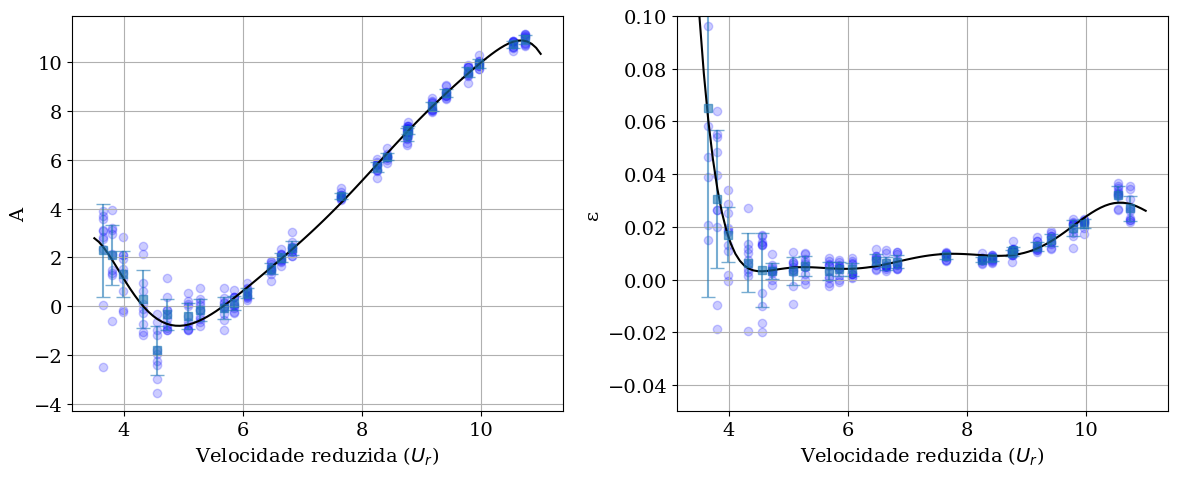

In [7]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for part_idx in range(n_parts):
    plt.scatter(U, A_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A_mean[sorted_idxs], yerr=A_std[sorted_idxs], fmt='s', alpha=0.6, capsize=5)
plt.plot(U_plot, A_plot, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('A')
plt.grid(True)

plt.subplot(1, 2, 2)
for part_idx in range(n_parts):
    plt.scatter(U, eps_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], eps_mean[sorted_idxs], yerr=eps_std[sorted_idxs], fmt='s', alpha = 0.6, capsize=5)
plt.plot(U_plot, eps_plot, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('ε')
plt.ylim([-0.05, .1])
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
n_samples = n_train
total_points = 18000
from scipy.interpolate import interp1d
block_size = 2000
method = 'RK45'
A_poly = np.load('./dados/A_poly.npy')
Eps_poly = np.load('./dados/Eps_poly.npy')

def om_system(t, u, eps, A, Ur):
    q, q_pd, y, y_pd = u
    S = St * Ur

    term1 = (Ur**2 / (2 * np.pi**3 * (m_o + Ca_pot)))
    term2 = (c * q - 2 * np.pi * C_dv * y_pd / Ur) * np.sqrt(1 + (2 * np.pi * y_pd / Ur)**2)
    y_sd = term1 * term2 - 2 * Xi_y * y_pd - y

    q_sd = A * y_sd - eps * S * (q**2 - 1) * q_pd - S**2 * q

    return [q_pd, q_sd, y_pd, y_sd]

Y_rctd_pol = np.zeros((n_samples, total_points))
Q_rctd_pol = np.zeros((n_samples, total_points))
Y_rctd_pol_parts = np.zeros((n_parts, n_samples, total_points))
Q_rctd_pol_parts = np.zeros((n_parts, n_samples, total_points))

for i in tqdm(range(n_samples), desc="Processando amostras"):
  Ur_val = U[i]
  T_sample = T[i, :]
  current_state = [
      Q_filtered[i, 0],
      Q_pd_filtered[i, 0],
      Y_filtered[i, 0],
      Y_pd_filtered[i, 0]
  ]

  all_t2 = []
  all_y2 = []
  all_q2 = []

  for block in range(int(np.ceil(total_points/block_size))):
      start = block * block_size
      end = min((block + 1) * block_size, total_points)
      t_block = T_sample[start:end]
      sol = solve_ivp(
          fun=lambda t, u: om_system(t, u, Eps_poly[i], A_poly[i], Ur_val),
          t_span=[t_block[0], t_block[-1]],
          y0=current_state,
          t_eval=t_block,
          method=method,
          rtol=1e-5,
          atol=1e-7
      )

      all_t2.extend(sol.t)
      all_y2.extend(sol.y[2])
      all_q2.extend(sol.y[0])
      current_state = [sol.y[k, -1] for k in range(4)]
      y_intrp1 = interp1d(all_t2, all_y2, kind='linear', fill_value="extrapolate")
      q_intrp1 = interp1d(all_t2, all_q2, kind='linear', fill_value="extrapolate")
      Y_rctd_pol[i, :] = y_intrp1(T_sample)
      Q_rctd_pol[i, :] = q_intrp1(T_sample)

  for part in range(n_parts):
        current_state = [
            Q_filtered_parts[part, i, 0],
            Q_pd_filtered_parts[part, i, 0],
            Y_filtered_parts[part, i, 0],
            Y_pd_filtered_parts[part, i, 0]
        ]

        all_t2 = []
        all_y2 = []
        all_q2 = []

        for block in range(int(np.ceil(total_points/block_size))):
            start = block * block_size
            end = min((block + 1) * block_size, total_points)
            t_block = T_sample[start:end]
            sol = solve_ivp(
                fun=lambda t, u: om_system(t, u, eps_parts[part, i], A_parts[part, i], Ur_val),
                t_span=[t_block[0], t_block[-1]],
                y0=current_state,
                t_eval=t_block,
                method=method,
                rtol=1e-5,
                atol=1e-7
            )

            all_t2.extend(sol.t)
            all_y2.extend(sol.y[2])
            all_q2.extend(sol.y[0])
            current_state = [sol.y[k, -1] for k in range(4)]
            y_intrp1 = interp1d(all_t2, all_y2, kind='linear', fill_value="extrapolate")
            q_intrp1 = interp1d(all_t2, all_q2, kind='linear', fill_value="extrapolate")
            Y_rctd_pol_parts[part, i, :] = y_intrp1(T_sample)
            Q_rctd_pol_parts[part, i, :] = q_intrp1(T_sample)


Processando amostras: 100%|██████████| 25/25 [01:45<00:00,  4.22s/it]


In [9]:
rms_experimental = np.array([np.sqrt(np.mean(allY[i, :]**2)) for i in range(all_n)])
rms_simulado_parts = np.array([[np.sqrt(np.mean(Y_rctd_pol_parts[part, i, :]**2)) for i in range(n_train)] for part in range(n_parts)])
rms_simulado = np.array([np.sqrt(np.mean(Y_rctd_pol[i, :]**2)) for i in range(n_train)])
rms_simulado_parts = np.where((rms_simulado_parts > 2),np.nan,rms_simulado_parts)
rms_simulado_std = np.array([np.std(rms_simulado_parts[:, i]) for i in range(n_train)])


In [10]:

rms_simulado_std

array([0.01195376, 0.01197308, 0.06950766, 0.12571473, 0.01612607,
       0.02462089, 0.12458001, 0.02332567, 0.02580283, 0.07024627,
       0.0627285 , 0.21064682, 0.04251214, 0.27783813, 0.15490473,
       0.01281653, 0.01266753, 0.01754787, 0.30122401, 0.36640362,
       0.1033345 , 0.01839664, 0.025748  ,        nan, 0.01167159])

<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-532693595.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('RMS ( ${\overline{y^2}}$ )')


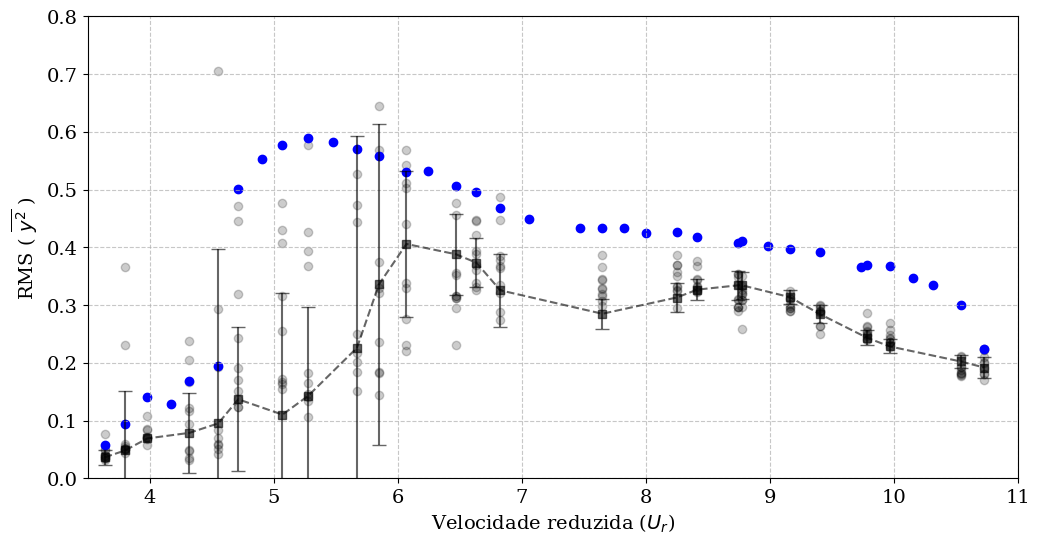

In [11]:
plt.figure(figsize=(12, 6))


for part_idx in range(n_parts):
    plt.scatter(U, rms_simulado_parts[part_idx, :], color='black', alpha=0.2, label=f'Parte {part_idx+1}')
plt.scatter(allU, rms_experimental, color='blue', label='Experimental')
plt.errorbar(U[sorted_idxs], rms_simulado[sorted_idxs],
             yerr=rms_simulado_std[sorted_idxs], color='black',
             linestyle='--',fmt='s', alpha=0.6, capsize=5)

plt.ylim(0, .8)
plt.xlim(3.5, 11)
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('RMS ( ${\overline{y^2}}$ )')
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [12]:
A_parts_rms = np.load('./dados/A_parts_rms.npy')
eps_parts_rms = np.load('./dados/eps_parts_rms.npy')

A_mean_rms = np.mean(A_parts_rms, axis=0)
eps_mean_rms = np.mean(eps_parts_rms, axis=0)
A_std_rms = np.std(A_parts_rms, axis=0)
eps_std_rms = np.std(eps_parts_rms, axis=0)

A_poly_rms = np.load('./dados/coeff_A_rms.npy')
eps_poly_rms = np.load('./dados/coeff_eps_rms.npy')

A_plot_rms = polynomial(U_plot, *A_poly_rms)
eps_plot_rms = polynomial(U_plot, *eps_poly_rms)

In [13]:
A_poly_rms

array([-1.02950951e-03,  5.85355959e-02, -1.42724780e+00,  1.94651443e+01,
       -1.62181819e+02,  8.44114009e+02, -2.67611799e+03,  4.71864651e+03,
       -3.53010220e+03])

In [16]:
eps_poly_rms


array([-3.30415648e-04,  1.85157612e-02, -4.46917439e-01,  6.06777225e+00,
       -5.06806405e+01,  2.66647894e+02, -8.62731810e+02,  1.56810014e+03,
       -1.22379491e+03])

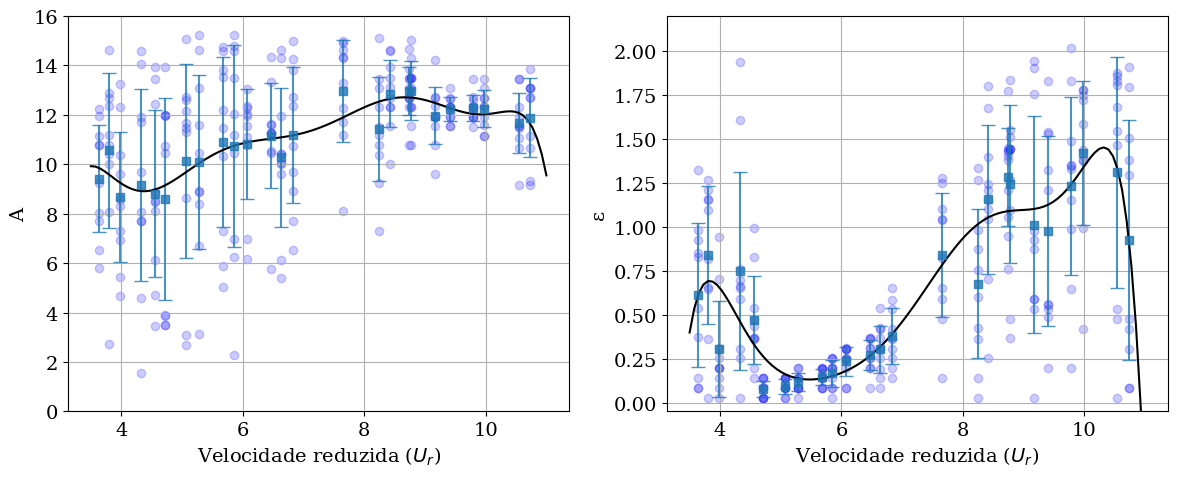

In [ ]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for part_idx in range(n_parts):
    plt.scatter(U, A_parts_rms[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A_mean_rms[sorted_idxs], yerr=A_std_rms[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
plt.plot(U_plot, A_plot_rms, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('A')
plt.ylim([0, 16])
plt.grid(True)

plt.subplot(1, 2, 2)
for part_idx in range(n_parts):
    plt.scatter(U, eps_parts_rms[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], eps_mean_rms[sorted_idxs], yerr=eps_std_rms[sorted_idxs], fmt='s', alpha = 0.8, capsize=5)
plt.plot(U_plot, eps_plot_rms, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('ε')
plt.ylim([-0.05, 2.2])
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
n_samples = n_train
total_points = 18000
from scipy.interpolate import interp1d
block_size = 2000
method = 'RK45'
A_poly_rms = np.load('./dados/A_poly_rms.npy')
Eps_poly_rms = np.load('./dados/Eps_poly_rms.npy')

Y_rctd_pol_rms = np.zeros((n_samples, total_points))
Q_rctd_pol_rms = np.zeros((n_samples, total_points))
Y_rctd_pol_parts_rms = np.zeros((n_parts, n_samples, total_points))
Q_rctd_pol_parts_rms = np.zeros((n_parts, n_samples, total_points))

for i in tqdm(range(n_samples), desc="Processando amostras"):
  Ur_val = U[i]
  T_sample = T[i, :]
  current_state = [
      Q_filtered[i, 0],
      Q_pd_filtered[i, 0],
      Y_filtered[i, 0],
      Y_pd_filtered[i, 0]
  ]

  all_t2 = []
  all_y2 = []
  all_q2 = []

  for block in range(int(np.ceil(total_points/block_size))):
      start = block * block_size
      end = min((block + 1) * block_size, total_points)
      t_block = T_sample[start:end]
      sol = solve_ivp(
          fun=lambda t, u: om_system(t, u, Eps_poly_rms[i], A_poly_rms[i], Ur_val),
          t_span=[t_block[0], t_block[-1]],
          y0=current_state,
          t_eval=t_block,
          method=method,
          rtol=1e-5,
          atol=1e-7
      )

      all_t2.extend(sol.t)
      all_y2.extend(sol.y[2])
      all_q2.extend(sol.y[0])
      current_state = [sol.y[k, -1] for k in range(4)]
      y_intrp1 = interp1d(all_t2, all_y2, kind='linear', fill_value="extrapolate")
      q_intrp1 = interp1d(all_t2, all_q2, kind='linear', fill_value="extrapolate")
      Y_rctd_pol_rms[i, :] = y_intrp1(T_sample)
      Q_rctd_pol_rms[i, :] = q_intrp1(T_sample)

  for part in range(n_parts):
        current_state = [
            Q_filtered_parts[part, i, 0],
            Q_pd_filtered_parts[part, i, 0],
            Y_filtered_parts[part, i, 0],
            Y_pd_filtered_parts[part, i, 0]
        ]

        all_t2 = []
        all_y2 = []
        all_q2 = []

        for block in range(int(np.ceil(total_points/block_size))):
            start = block * block_size
            end = min((block + 1) * block_size, total_points)
            t_block = T_sample[start:end]
            sol = solve_ivp(
                fun=lambda t, u: om_system(t, u, eps_parts_rms[part, i], A_parts_rms[part, i], Ur_val),
                t_span=[t_block[0], t_block[-1]],
                y0=current_state,
                t_eval=t_block,
                method=method,
                rtol=1e-5,
                atol=1e-7
            )

            all_t2.extend(sol.t)
            all_y2.extend(sol.y[2])
            all_q2.extend(sol.y[0])
            current_state = [sol.y[k, -1] for k in range(4)]
            y_intrp1 = interp1d(all_t2, all_y2, kind='linear', fill_value="extrapolate")
            q_intrp1 = interp1d(all_t2, all_q2, kind='linear', fill_value="extrapolate")
            Y_rctd_pol_parts_rms[part, i, :] = y_intrp1(T_sample)
            Q_rctd_pol_parts_rms[part, i, :] = q_intrp1(T_sample)


Processando amostras: 100%|██████████| 25/25 [06:44<00:00, 16.20s/it]


In [ ]:
rms_simulado_parts_rms = np.array([[np.sqrt(np.mean(Y_rctd_pol_parts_rms[part, i, :]**2)) for i in range(n_train)] for part in range(n_parts)])
rms_simulado_rms = np.array([np.sqrt(np.mean(Y_rctd_pol_rms[i, :]**2)) for i in range(n_train)])
rms_simulado_parts_rms = np.where((rms_simulado_parts_rms > 2),np.nan,rms_simulado_parts_rms)
rms_simulado_std_rms = np.array([np.std(rms_simulado_parts_rms[:, i]) for i in range(n_train)])



<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-2666134996.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('RMS ( ${\overline{y^2}}$ )')


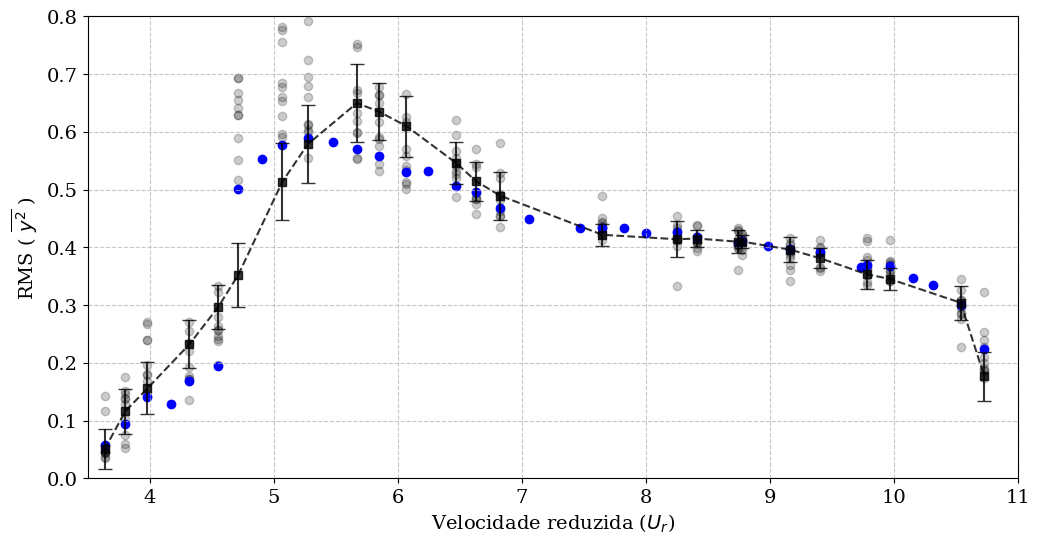

In [ ]:
plt.figure(figsize=(12, 6))


for part_idx in range(n_parts):
    plt.scatter(U, rms_simulado_parts_rms[part_idx, :], color='black', alpha=0.2, label=f'Parte {part_idx+1}')
plt.scatter(allU, rms_experimental, color='blue', label='Experimental')
plt.errorbar(U[sorted_idxs], rms_simulado_rms[sorted_idxs],
             yerr=rms_simulado_std_rms[sorted_idxs], color='black',
             linestyle='--',fmt='s', alpha=0.8, capsize=5)

plt.ylim(0, .8)
plt.xlim(3.5, 11)
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('RMS ( ${\overline{y^2}}$ )')
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()